In [130]:
import sys
import time
import json
import requests
import warnings
import importlib
import numpy as np
import pandas as pd
import pickle as pkl
import pandas as pd
import os
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
import matplotlib.pyplot as plt

import h3
import h3pandas

import src
from src.reload import deep_reload

from pathlib import Path

In [2]:
'''
generating demographic data GeoDataFrame for Colorado using src.pull_data
 - this writes a .pkl in Data/Generated_Data
 - can also be called from the command line
'''
deep_reload(src)
src.pull_data.PullData(state_FIPS='08',path_to_data='Data/')

Loading in the shells .csv: 0.0350 seconds
Pulling race data:

100%|██████████| 7/7 [00:07<00:00,  1.03s/it]


 8.5577 seconds
Pulling housing type and tenure data:

100%|██████████| 12/12 [00:12<00:00,  1.03s/it]


 13.2886 seconds
Pulling median income data:

0it [00:00, ?it/s]


 1.0986 seconds
Loading in census tract geometry data: 8.3342 seconds
Sorting the DataFrames: 0.0032 seconds
Joining the DataFrames: 0.0034 seconds
Pickling: 0.0115 seconds
Done


In [3]:
#Loading in the demographic data generated using src.pull_data
deep_reload(src)
acs_gdf=src.pull_data.LoadACSData('Data/Generated_Data/Census_Tract_Demographic_Data_08.pkl')

In [4]:
#Down-selecting by proximity to central Denver (25 km radius)
deep_reload(src)
lon=-104.989079
lat=39.779970
radius=25000
#Data for selected tracts
gdf_selected=src.calculations.DownSlectBlocks(acs_gdf,lon,lat,radius)
#Background for plotting
gdf_background=src.calculations.DownSlectBlocks(acs_gdf,lon,lat,radius*3)

In [5]:
#Making empty H3 hex cells to match the census tracts (https://h3geo.org/, https://pypi.org/project/h3/, https://pypi.org/project/h3pandas/)
#Using resolution 8
deep_reload(src)
gdf_hex_8=src.h3_hex.MakeEmptyHex(gdf_selected,resolution=8)

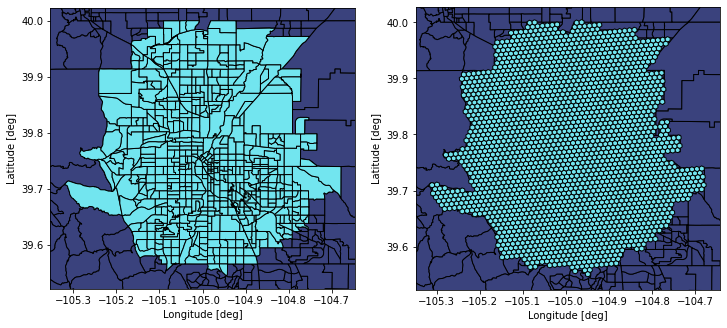

In [6]:
#Plot showing census tracks and H3 Hex
deep_reload(src)
fig=src.figures.TractsHexComparisonPlot(gdf_selected,gdf_hex_8,gdf_background)

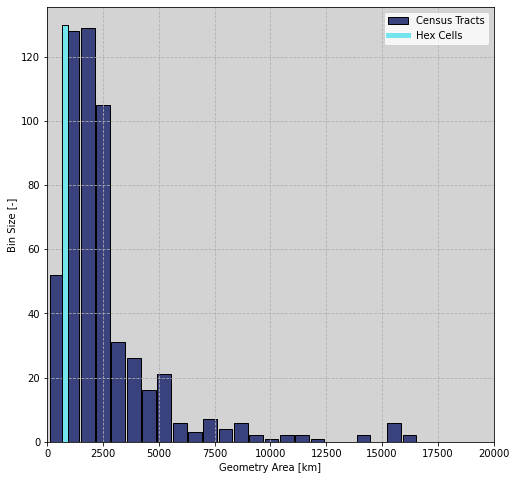

In [7]:
#Comparing sizes of tracts to hex cells
deep_reload(src)
fig=src.figures.TractsHexAreaHistogram(gdf_selected,gdf_hex_8)

In [34]:
#Converting demographic data to H3 cells for calculations
deep_reload(src)
default_interpolation_keys=['Total_Housing','Owned', '1 Owned', '2 to 4 Owned',
        '5+ Owned', 'Mobile Home Owned',
        'Other Owned', 'Rented', '1 Rented', '2 to 4 Rented', '5+ Rented',
        'Mobile Home Rented', 'Other Rented', 'Total_Race',
        'White Alone', 'Black or African American Alone',
        'American Indian and Alaska Native Alone', 'Asian Alone',
        'Native Hawaiian and Other Pacific Islander Alone',
        'Some Other Race Alone', 'Two or More Races']

default_keep_closest_keys=['Median Income']
gdf_hex_data=src.h3_hex.DataToHex(gdf_selected,gdf_hex_8,interpolation_keys=default_interpolation_keys,
    keep_closest_keys=default_keep_closest_keys)

In [32]:
indices=np.zeros(gdf_hex_8.shape[0])
contained=0
for idx in range(gdf_hex_8.shape[0]):
    # print(gdf_selected.contains(gdf_hex_8['geometry'][idx]))
    # print(gdf_selected.contains(gdf_hex_8['geometry'][idx]).sum())
    contained+=gdf_selected.contains(gdf_hex_8['geometry'][idx].centroid).sum()
    # if idx==50:
    #     break
contained,gdf_hex_8.shape[0]

(2254, 2254)

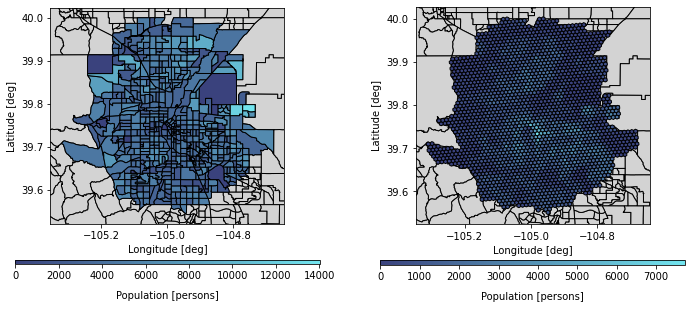

In [35]:
#Comparing population to hex cells
deep_reload(src)
fig=src.figures.DataColumnComparisonPlot(gdf_selected,gdf_hex_data,gdf_background,
                               column='Total_Housing',
                               color_axis_label='Population [persons]',
                               colors=np.flip(src.figures.color_scheme_2_1))

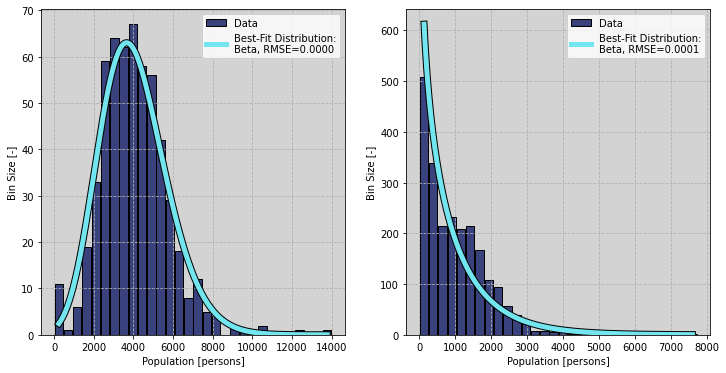

In [90]:
deep_reload(src)
fig=src.figures.HistogramComparisonPlot(gdf_selected,gdf_hex_data,column=['Total_Housing'],data_label='Population [persons]',bins=30)

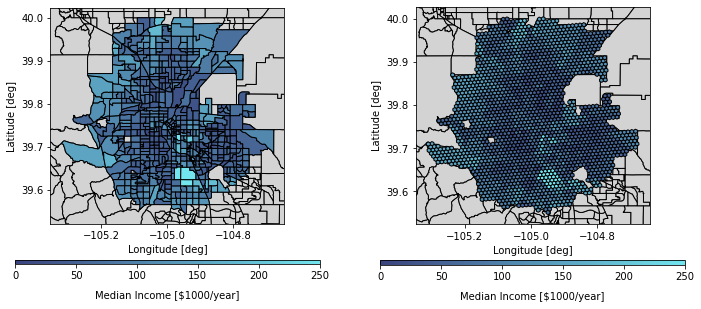

In [69]:
#Comparing median income to hex cells
deep_reload(src)
gdf_selected['Median Income 1000']=gdf_selected['Median Income']/1000
gdf_hex_data['Median Income 1000']=gdf_hex_data['Median Income']/1000
fig=src.figures.DataColumnComparisonPlot(gdf_selected,gdf_hex_data,gdf_background,
                               column='Median Income 1000',
                               color_axis_label='Median Income [$1000/year]',
                               colors=np.flip(src.figures.color_scheme_2_1))

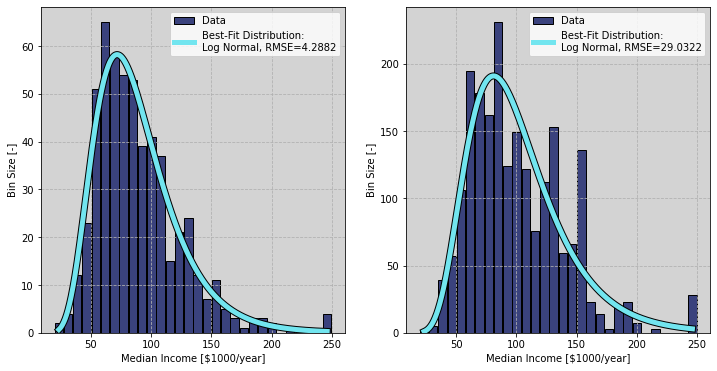

In [104]:
deep_reload(src)
fig=src.figures.HistogramComparisonPlot(gdf_selected,gdf_hex_data,column=['Median Income 1000'],data_label='Median Income [$1000/year]',bins=30)

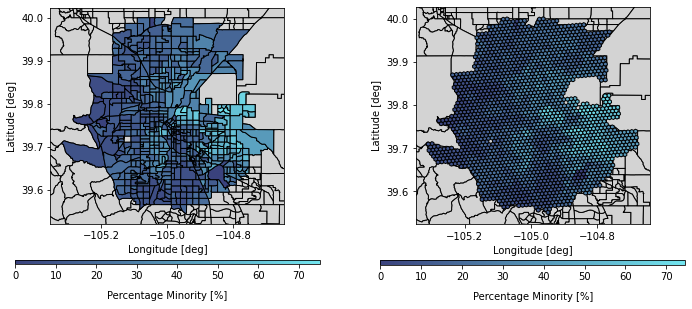

In [92]:
#Comparing percentage of minority residents to hex cells
deep_reload(src)
gdf_selected['Minority Percentage']=(gdf_selected['Total_Race']-gdf_selected['White Alone'])/gdf_selected['Total_Race']*100
gdf_hex_data['Minority Percentage']=(gdf_hex_data['Total_Race']-gdf_hex_data['White Alone'])/gdf_hex_data['Total_Race']*100
fig=src.figures.DataColumnComparisonPlot(gdf_selected,gdf_hex_data,gdf_background,
                               column='Minority Percentage',
                               color_axis_label='Percentage Minority [%]',
                               colors=np.flip(src.figures.color_scheme_2_1))

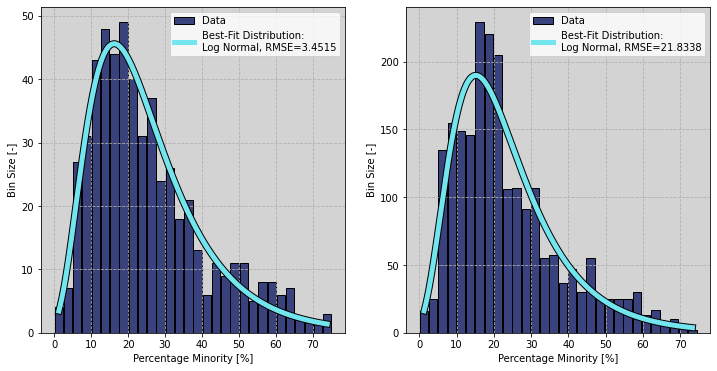

In [103]:
deep_reload(src)
fig=src.figures.HistogramComparisonPlot(gdf_selected,gdf_hex_data,column=['Minority Percentage'],data_label='Percentage Minority [%]',bins=30)

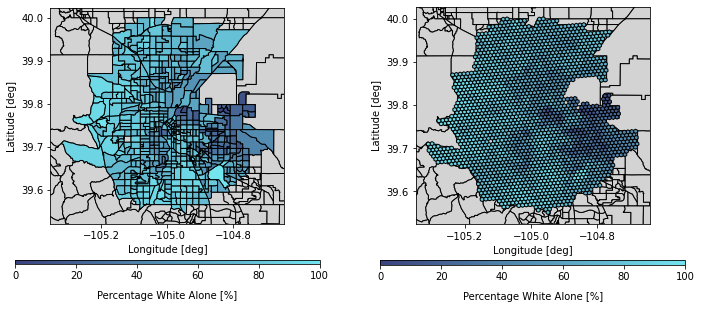

In [94]:
#Comparing percentage of white residents to hex cells
deep_reload(src)
gdf_selected['White Alone Percentage']=(gdf_selected['White Alone'])/gdf_selected['Total_Race']*100
gdf_hex_data['White Alone Percentage']=(gdf_hex_data['White Alone'])/gdf_hex_data['Total_Race']*100
fig=src.figures.DataColumnComparisonPlot(gdf_selected,gdf_hex_data,gdf_background,
                               column='White Alone Percentage',
                               color_axis_label='Percentage White Alone [%]',
                               colors=np.flip(src.figures.color_scheme_2_1))

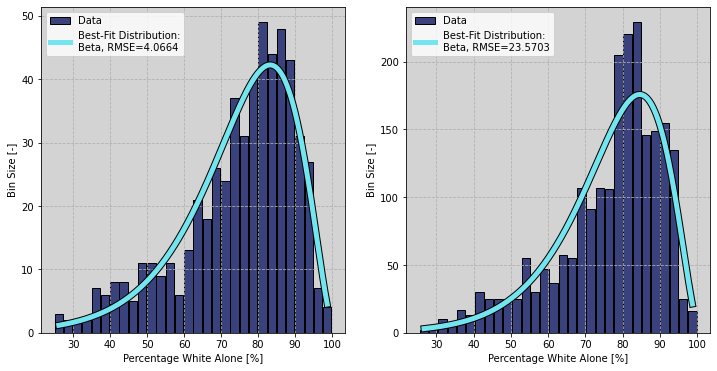

In [102]:
deep_reload(src)
fig=src.figures.HistogramComparisonPlot(gdf_selected,gdf_hex_data,column=['White Alone Percentage'],data_label='Percentage White Alone [%]',bins=30)

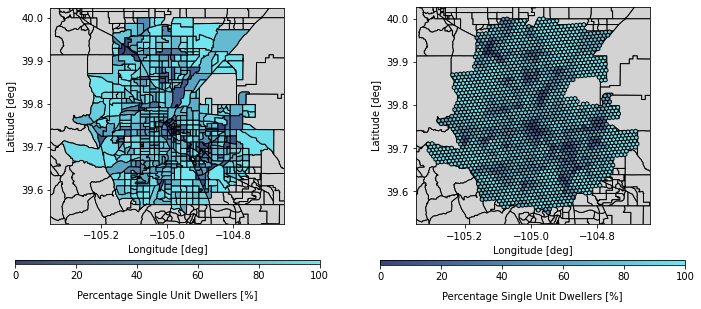

In [97]:
#Comparing percentage of single unit dwellers to hex cells
deep_reload(src)
gdf_selected['Single Unit Percentage']=(gdf_selected['1 Owned']+gdf_selected['1 Rented'])/gdf_selected['Total_Housing']*100
gdf_hex_data['Single Unit Percentage']=(gdf_hex_data['1 Owned']+gdf_hex_data['1 Rented'])/gdf_hex_data['Total_Housing']*100
fig=src.figures.DataColumnComparisonPlot(gdf_selected,gdf_hex_data,gdf_background,
                               column='Single Unit Percentage',
                               color_axis_label='Percentage Single Unit Dwellers [%]',
                               colors=np.flip(src.figures.color_scheme_2_1))

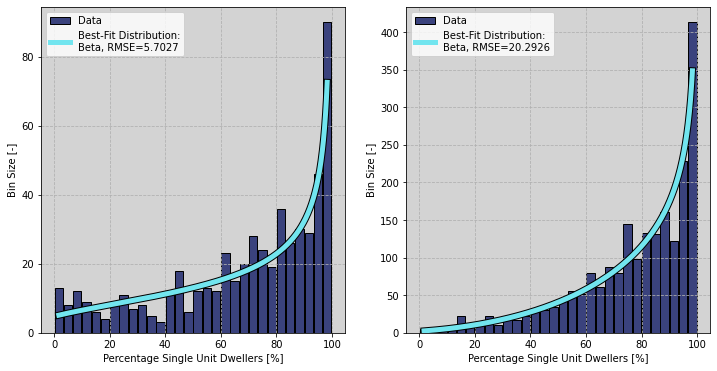

In [111]:
deep_reload(src)
fig=src.figures.HistogramComparisonPlot(gdf_selected,gdf_hex_data,column='Single Unit Percentage',data_label='Percentage Single Unit Dwellers [%]',bins=30)

In [128]:
#Loading in the NHTS data to make itineraries
deep_reload(src)
NHTS_df=src.process_nhts_data.LoadNHTSData('Data/NHTS_2017/trippub.csv')

In [145]:
#Processing itineraries for the NHTS data
if Path('Data/Generated_Data/NHTS_Itineraries.pkl').is_file():
    pass
else:
    NHTS_itineraries=src.process_nhts_data.CreateItineraries(NHTS_df)

In [146]:
#Loading the NHTS Data
deep_reload(src)
itin=pkl.load(open('Data/Generated_Data/NHTS_Itineraries.pkl','rb'))

In [166]:
#Creating datasets for National, Colorado, and Denver MSA
itin_national=itin
itin_colorado=src.process_nhts_data.FilterByAttribute(itin_national,'hh_state','8')
itin_denver_msa=src.process_nhts_data.FilterByAttribute(itin_national,'hh_msa','19740')

100%|██████████| 153351/153351 [00:00<00:00, 1586539.86it/s]
